# 光谱识别-孟德尔的豌豆田

## 导包、预定义

In [2]:
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.signal
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import argrelextrema
from scipy.spatial.distance import cdist

# 定义数据目录
directories = [
    "./data/library/txt/",
    "./data/library/csv/",
    "./data/test/single/txt/",
    "./data/test/single/csv/",
    "./data/test/multi/txt/",
    "./data/test/multi/csv/",
    ]


## 建立光谱库

In [3]:
def create_library(directory):
    library = {}
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            mine_name = filename.split(".")[0]
            with open(os.path.join(directory, filename), 'r') as f:
                df = pd.read_csv(f)
                library[mine_name] = df
                
    return library

spectrum_lib = create_library(directories[1])
test_lib = create_library(directories[3])

## 绘制光谱

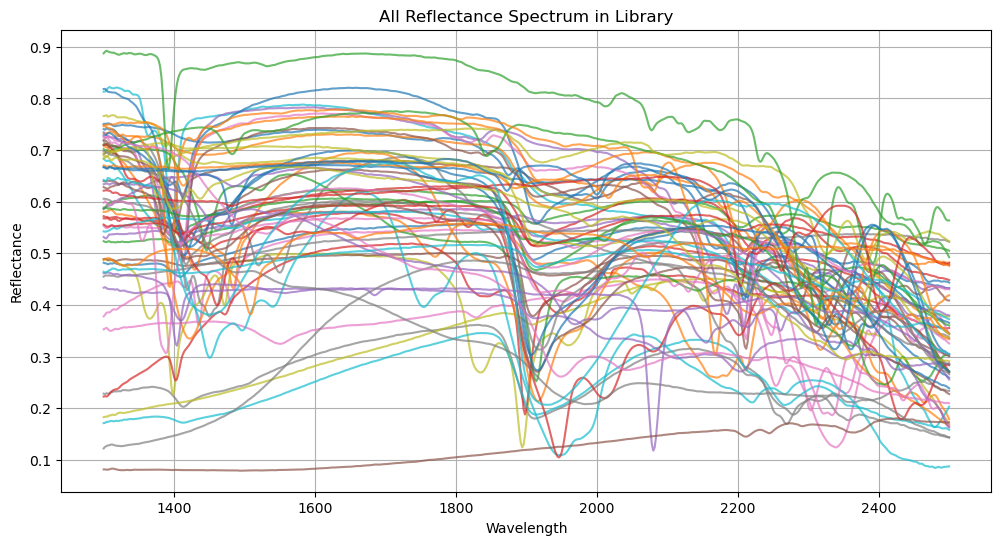

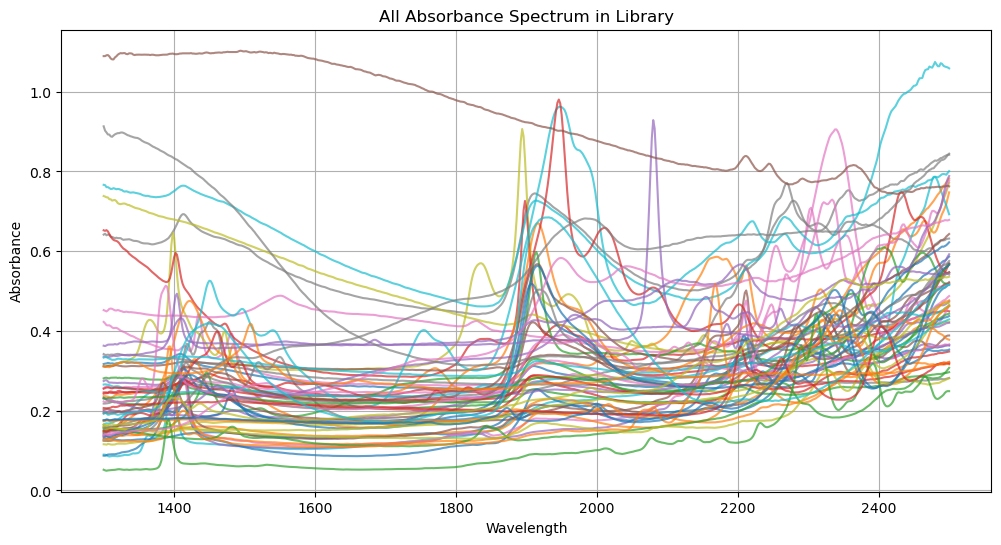

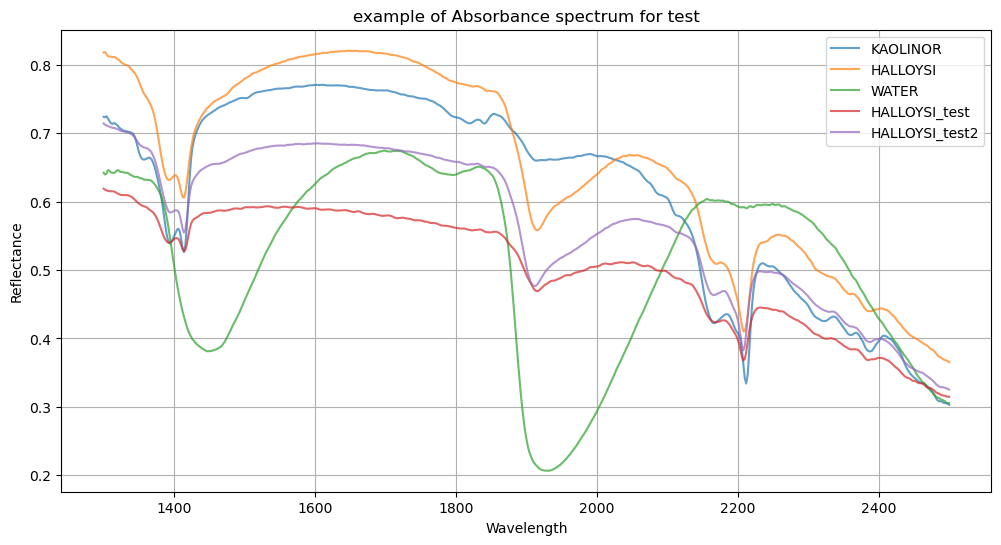

In [4]:
def plot_spectrums(spectrums, attr='absorbance', legend_added=True, title='Spectrum'):
    # 设置图表大小
    plt.figure(figsize=(12, 6))
    plot_ylabel=attr.capitalize()
    # 绘制图表
    for name, df in spectrums.items():
        plt.plot(df['wavelength'], df[attr], label=name, alpha=0.7)

    # 设置图表横纵坐标标签、标题、图例、网格
    plt.xlabel('Wavelength')
    plt.ylabel(plot_ylabel)
    plt.title(title)
    if legend_added:
        plt.legend()
    plt.grid(True)
    plt.show()

test_target_spectrum = {
    'KAOLINOR':spectrum_lib['KAOLINOR'],
    'HALLOYSI':spectrum_lib['HALLOYSI'],
    'WATER':spectrum_lib['WATER2'],
    'HALLOYSI_test':pd.read_csv('./data/test/single/csv/gb81078-HALL.csv'),
    'HALLOYSI_test2':pd.read_csv('./data/test/single/csv/mottled white and iron stained-HALL.csv'),
}
plot_spectrums(spectrum_lib,'reflectance',False,'All Reflectance Spectrum in Library')
plot_spectrums(spectrum_lib,legend_added = False, title='All Absorbance Spectrum in Library')
plot_spectrums(test_target_spectrum,'reflectance',title='example of Absorbance spectrum for test')

## 单光谱匹配

### 数据预处理

对光谱库中的数据进行预处理，包括基线校正、平滑、归一化、包络线去除

#### 归一化

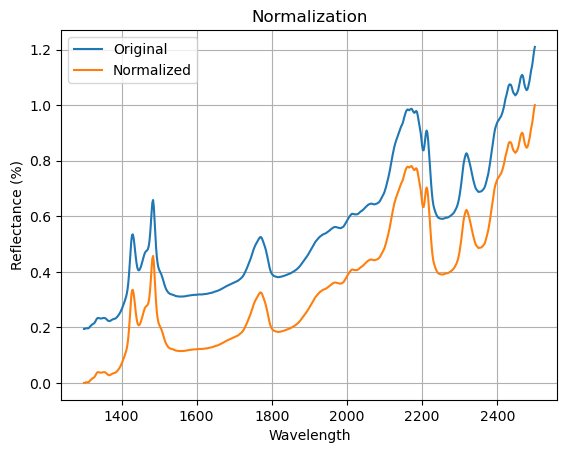

In [22]:
original_spectrum = spectrum_lib['ALUNITE1']
# 归一化
def normalize(spectrum):
    y = spectrum['absorbance']
    y_new = (y - y.min()) / (y.max() - y.min())
    spectrum['normalized'] = y_new
    return y_new

normalized_spectrum = normalize(original_spectrum)
original_spectrum['normalized'] = normalized_spectrum
plt.plot(original_spectrum['wavelength'], original_spectrum['absorbance'], label='Original')
plt.plot(original_spectrum['wavelength'], original_spectrum['normalized'], label='Normalized')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance (%)')
plt.title('Normalization')
plt.legend()
plt.grid(True)
plt.show()

#### 包络线消除

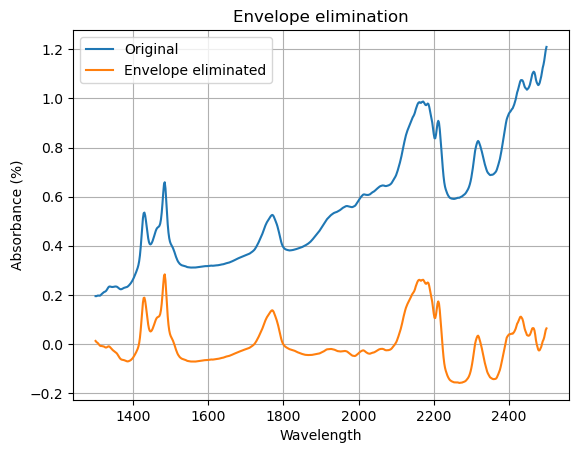

In [23]:
# 包络线消除
def envelope_elimination(spectrum, window=350):
    y = spectrum['normalized']
    y_max = scipy.signal.savgol_filter(y, window, 3)
    y_new = y - y_max
    spectrum['envelope_eliminated'] = y_new
    return y_new

envelope_eliminated_spectrum = envelope_elimination(original_spectrum)
plt.plot(original_spectrum['wavelength'], original_spectrum['absorbance'], label='Original')
plt.plot(original_spectrum['wavelength'], original_spectrum['envelope_eliminated'], label='Envelope eliminated')
plt.xlabel('Wavelength')
plt.ylabel('Absorbance (%)')
plt.title('Envelope elimination')
plt.legend()
plt.grid(True)
plt.show()


### 寻峰

[1430. 1484. 1770. 2172. 2212. 2318. 2432. 2464.]


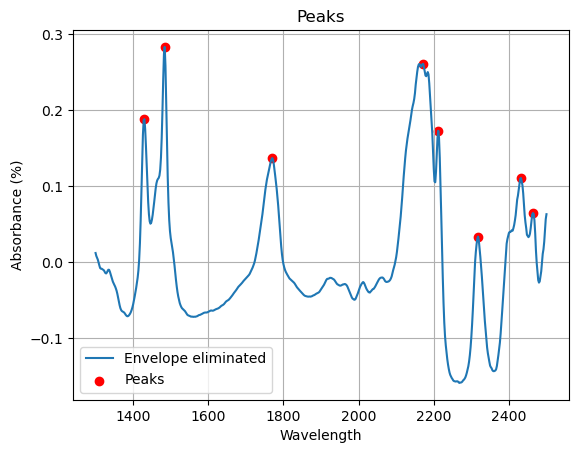

In [24]:
# 寻峰
def find_peaks(spectrum, attr='envelope_eliminated', threshold=0.02):
    y = spectrum[attr]
    peaks = argrelextrema(y.values, np.greater, order=5)
    peaks = peaks[0]

    # 计算每个峰的深度
    depths = np.zeros_like(peaks, dtype=float)
    for i, peak in enumerate(peaks):
        left_min = np.min(y.values[:peak]) if i == 0 else np.min(y.values[peaks[i-1]:peak])
        right_min = np.min(y.values[peak:peaks[i+1]]) if i < len(peaks) - 1 else np.min(y.values[peak:])
        depths[i] = y.values[peak] - max(left_min, right_min)

    # 根据深度而不是绝对高度筛选峰值
    peaks = peaks[depths > threshold]
    peaks_wavelength = spectrum['wavelength'].iloc[peaks].values
    return peaks, peaks_wavelength

peaks, peaks_wavelength = find_peaks(original_spectrum)
print(peaks_wavelength)
plt.plot(original_spectrum['wavelength'], original_spectrum['envelope_eliminated'], label='Envelope eliminated')
plt.scatter(peaks_wavelength, original_spectrum['envelope_eliminated'].iloc[peaks], color='red', label='Peaks')
plt.xlabel('Wavelength')
plt.ylabel('Absorbance (%)')
plt.title('Peaks')
plt.legend()
plt.grid(True)
plt.show()

def get_peak_wavelenghs_from_spectrum(spectrum):
    # 归一化
    normalized_spectrum = normalize(spectrum)
    # 包络线消除
    envelope_elimination_spectrum = envelope_elimination(spectrum)
    # 寻峰
    peaks, peaks_wavelength = find_peaks(spectrum)
    return peaks_wavelength

### 峰位匹配

A6K4-AL的相似度：{'ALBITE': 1, 'ALUNITE1': 6, 'ALUNITE2': 8, 'ANDESINE': 1, 'ANHYDRIT': 0, 'ANORTHIT': 0, 'ANTIGORI': 1, 'ANTLERIT': 1, 'AZURITE': 1, 'BERYL': 0, 'BRUCITE': 1, 'CALCITE1': 0, 'CALCITE2': 0, 'CALCITE3': 0, 'CERUSSIT': 0, 'CHRYSOPR': 1, 'CORDIERI': 1, 'DICKITE': 1, 'DICKITE2': 1, 'DOLOMIT1': 1, 'DOLOMIT2': 0, 'EPIDOTE1': 0, 'EPIDOTE2': 0, 'EPIDOTE3': 0, 'GIBBSITE': 0, 'GLAUCONI': 1, 'GYPSUM1': 0, 'GYPSUM2': 0, 'GYPSUM3': 0, 'HALLOYSI': 1, 'HEMIMORP': 0, 'HYDAPOPH': 0, 'ILLITE': 1, 'ILLITE2': 2, 'JAROSIT1': 0, 'JAROSIT2': 1, 'KAOLINDI': 2, 'KAOLINOR': 3, 'LABRADOR': 0, 'MAGNESI2': 0, 'MAGNESIT': 0, 'MALACHIT': 0, 'MONTMOR2': 2, 'MONTMORI': 2, 'MUSCOVIT': 1, 'NATROJAR': 1, 'NATROLIT': 1, 'NH4ILLIT': 1, 'NONTRON1': 2, 'NONTRON2': 1, 'OLIGOCLA': 0, 'PALYGORS': 0, 'PHLOGOPI': 1, 'PLUMJARO': 0, 'PREHNITE': 2, 'PYROPHYL': 3, 'RHODOCRO': 1, 'SCHEELIT': 0, 'SCORODIT': 0, 'SEPIOLIT': 0, 'SERPENTI': 2, 'SIDERITE': 1, 'SMITHSON': 0, 'SODALITE': 0, 'STILBITE': 0, 'STRONTIA': 0, 'TALC': 1, 

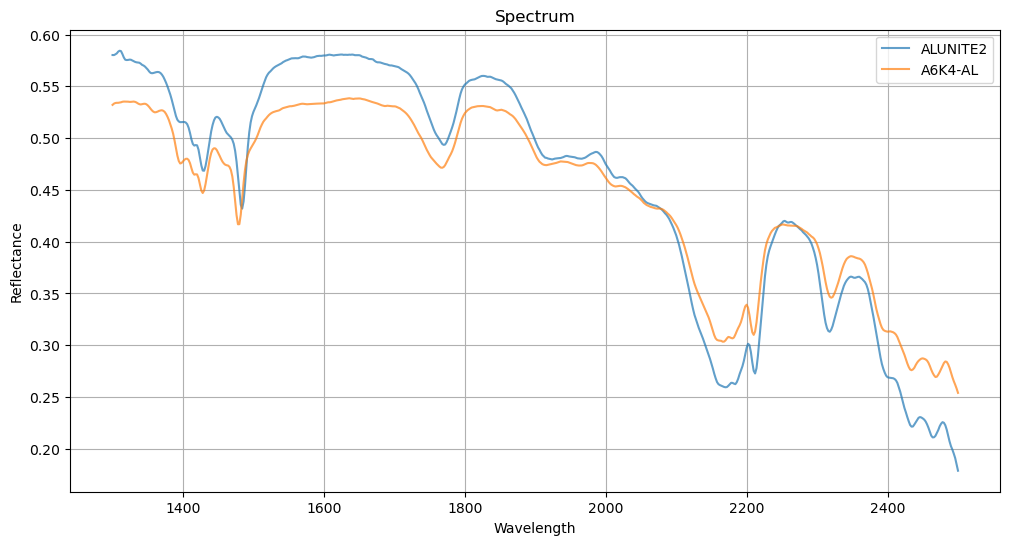

Alunite的相似度：{'ALBITE': 1, 'ALUNITE1': 6, 'ALUNITE2': 8, 'ANDESINE': 0, 'ANHYDRIT': 0, 'ANORTHIT': 1, 'ANTIGORI': 0, 'ANTLERIT': 1, 'AZURITE': 0, 'BERYL': 0, 'BRUCITE': 1, 'CALCITE1': 0, 'CALCITE2': 0, 'CALCITE3': 0, 'CERUSSIT': 0, 'CHRYSOPR': 0, 'CORDIERI': 1, 'DICKITE': 1, 'DICKITE2': 1, 'DOLOMIT1': 1, 'DOLOMIT2': 1, 'EPIDOTE1': 0, 'EPIDOTE2': 0, 'EPIDOTE3': 0, 'GIBBSITE': 0, 'GLAUCONI': 1, 'GYPSUM1': 0, 'GYPSUM2': 0, 'GYPSUM3': 0, 'HALLOYSI': 1, 'HEMIMORP': 0, 'HYDAPOPH': 0, 'ILLITE': 1, 'ILLITE2': 2, 'JAROSIT1': 0, 'JAROSIT2': 2, 'KAOLINDI': 2, 'KAOLINOR': 3, 'LABRADOR': 0, 'MAGNESI2': 0, 'MAGNESIT': 0, 'MALACHIT': 0, 'MONTMOR2': 2, 'MONTMORI': 2, 'MUSCOVIT': 1, 'NATROJAR': 1, 'NATROLIT': 1, 'NH4ILLIT': 1, 'NONTRON1': 2, 'NONTRON2': 1, 'OLIGOCLA': 0, 'PALYGORS': 0, 'PHLOGOPI': 1, 'PLUMJARO': 0, 'PREHNITE': 2, 'PYROPHYL': 3, 'RHODOCRO': 1, 'SCHEELIT': 0, 'SCORODIT': 0, 'SEPIOLIT': 0, 'SERPENTI': 2, 'SIDERITE': 1, 'SMITHSON': 0, 'SODALITE': 0, 'STILBITE': 0, 'STRONTIA': 0, 'TALC': 1, 

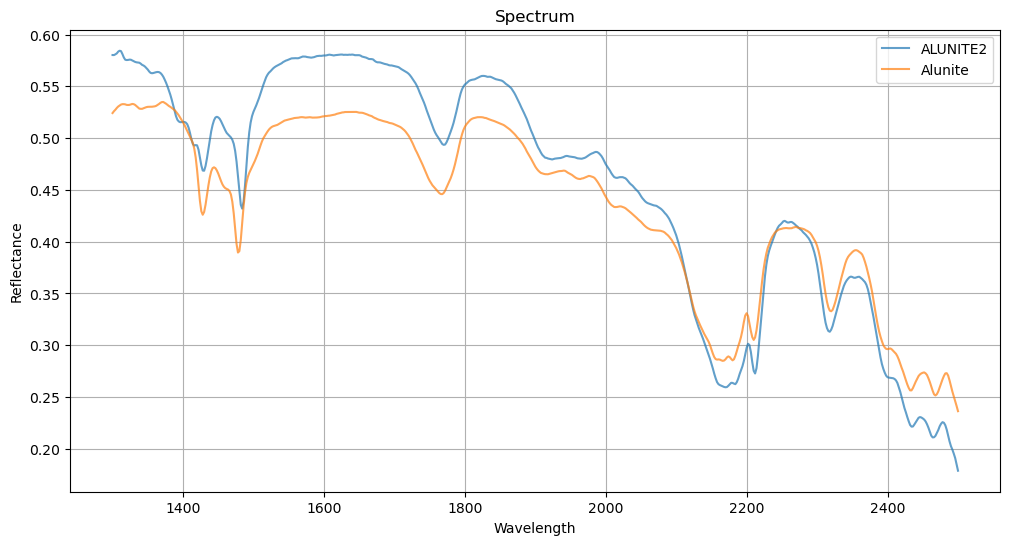

broken white surface的相似度：{'ALBITE': 3, 'ALUNITE1': 1, 'ALUNITE2': 2, 'ANDESINE': 4, 'ANHYDRIT': 0, 'ANORTHIT': 0, 'ANTIGORI': 1, 'ANTLERIT': 0, 'AZURITE': 2, 'BERYL': 1, 'BRUCITE': 0, 'CALCITE1': 0, 'CALCITE2': 1, 'CALCITE3': 0, 'CERUSSIT': 0, 'CHRYSOPR': 2, 'CORDIERI': 0, 'DICKITE': 3, 'DICKITE2': 3, 'DOLOMIT1': 0, 'DOLOMIT2': 0, 'EPIDOTE1': 0, 'EPIDOTE2': 0, 'EPIDOTE3': 0, 'GIBBSITE': 1, 'GLAUCONI': 1, 'GYPSUM1': 0, 'GYPSUM2': 0, 'GYPSUM3': 0, 'HALLOYSI': 4, 'HEMIMORP': 1, 'HYDAPOPH': 1, 'ILLITE': 3, 'ILLITE2': 4, 'JAROSIT1': 0, 'JAROSIT2': 0, 'KAOLINDI': 4, 'KAOLINOR': 4, 'LABRADOR': 1, 'MAGNESI2': 1, 'MAGNESIT': 0, 'MALACHIT': 2, 'MONTMOR2': 2, 'MONTMORI': 3, 'MUSCOVIT': 3, 'NATROJAR': 0, 'NATROLIT': 1, 'NH4ILLIT': 4, 'NONTRON1': 2, 'NONTRON2': 1, 'OLIGOCLA': 2, 'PALYGORS': 1, 'PHLOGOPI': 3, 'PLUMJARO': 0, 'PREHNITE': 1, 'PYROPHYL': 0, 'RHODOCRO': 0, 'SCHEELIT': 4, 'SCORODIT': 0, 'SEPIOLIT': 1, 'SERPENTI': 0, 'SIDERITE': 0, 'SMITHSON': 0, 'SODALITE': 0, 'STILBITE': 0, 'STRONTIA': 0

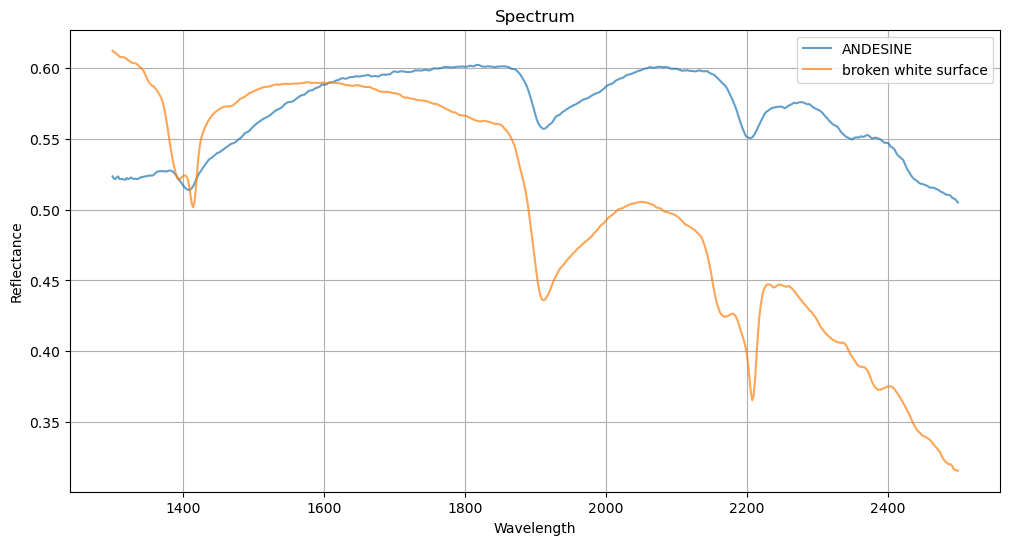

gb81075-HALL的相似度：{'ALBITE': 1, 'ALUNITE1': 1, 'ALUNITE2': 1, 'ANDESINE': 3, 'ANHYDRIT': 0, 'ANORTHIT': 1, 'ANTIGORI': 1, 'ANTLERIT': 0, 'AZURITE': 2, 'BERYL': 1, 'BRUCITE': 0, 'CALCITE1': 0, 'CALCITE2': 2, 'CALCITE3': 0, 'CERUSSIT': 0, 'CHRYSOPR': 2, 'CORDIERI': 0, 'DICKITE': 3, 'DICKITE2': 3, 'DOLOMIT1': 0, 'DOLOMIT2': 0, 'EPIDOTE1': 0, 'EPIDOTE2': 0, 'EPIDOTE3': 0, 'GIBBSITE': 1, 'GLAUCONI': 0, 'GYPSUM1': 0, 'GYPSUM2': 0, 'GYPSUM3': 0, 'HALLOYSI': 4, 'HEMIMORP': 2, 'HYDAPOPH': 1, 'ILLITE': 1, 'ILLITE2': 2, 'JAROSIT1': 0, 'JAROSIT2': 0, 'KAOLINDI': 3, 'KAOLINOR': 3, 'LABRADOR': 1, 'MAGNESI2': 0, 'MAGNESIT': 1, 'MALACHIT': 2, 'MONTMOR2': 2, 'MONTMORI': 2, 'MUSCOVIT': 2, 'NATROJAR': 0, 'NATROLIT': 1, 'NH4ILLIT': 2, 'NONTRON1': 1, 'NONTRON2': 0, 'OLIGOCLA': 1, 'PALYGORS': 2, 'PHLOGOPI': 2, 'PLUMJARO': 0, 'PREHNITE': 0, 'PYROPHYL': 0, 'RHODOCRO': 0, 'SCHEELIT': 3, 'SCORODIT': 0, 'SEPIOLIT': 2, 'SERPENTI': 0, 'SIDERITE': 0, 'SMITHSON': 0, 'SODALITE': 1, 'STILBITE': 1, 'STRONTIA': 0, 'TALC'

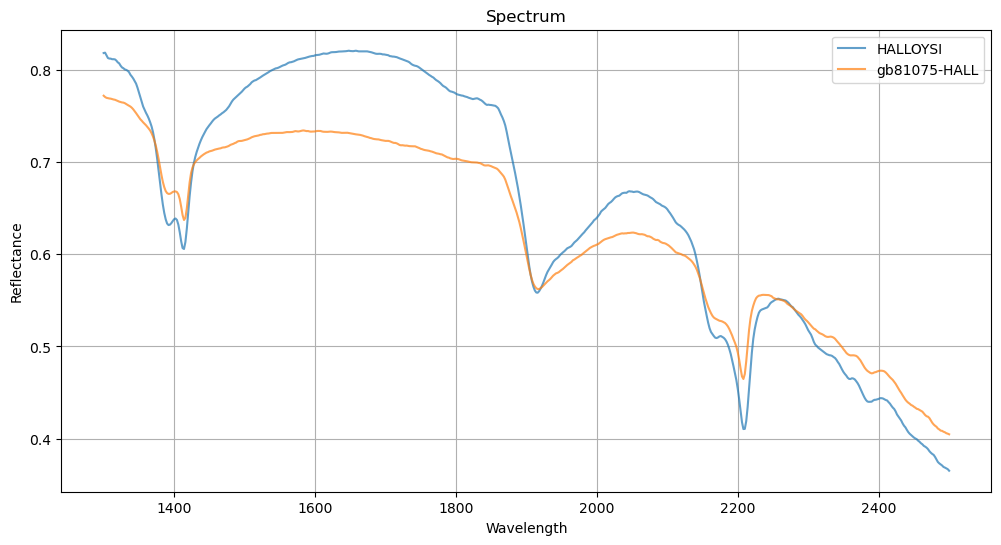

gb81078-HALL的相似度：{'ALBITE': 2, 'ALUNITE1': 2, 'ALUNITE2': 3, 'ANDESINE': 3, 'ANHYDRIT': 0, 'ANORTHIT': 1, 'ANTIGORI': 3, 'ANTLERIT': 0, 'AZURITE': 2, 'BERYL': 1, 'BRUCITE': 1, 'CALCITE1': 0, 'CALCITE2': 2, 'CALCITE3': 0, 'CERUSSIT': 0, 'CHRYSOPR': 2, 'CORDIERI': 0, 'DICKITE': 3, 'DICKITE2': 3, 'DOLOMIT1': 1, 'DOLOMIT2': 0, 'EPIDOTE1': 0, 'EPIDOTE2': 0, 'EPIDOTE3': 1, 'GIBBSITE': 1, 'GLAUCONI': 1, 'GYPSUM1': 0, 'GYPSUM2': 0, 'GYPSUM3': 0, 'HALLOYSI': 4, 'HEMIMORP': 2, 'HYDAPOPH': 1, 'ILLITE': 2, 'ILLITE2': 2, 'JAROSIT1': 0, 'JAROSIT2': 0, 'KAOLINDI': 4, 'KAOLINOR': 6, 'LABRADOR': 1, 'MAGNESI2': 0, 'MAGNESIT': 1, 'MALACHIT': 2, 'MONTMOR2': 2, 'MONTMORI': 2, 'MUSCOVIT': 2, 'NATROJAR': 0, 'NATROLIT': 1, 'NH4ILLIT': 2, 'NONTRON1': 1, 'NONTRON2': 0, 'OLIGOCLA': 1, 'PALYGORS': 2, 'PHLOGOPI': 3, 'PLUMJARO': 0, 'PREHNITE': 1, 'PYROPHYL': 3, 'RHODOCRO': 1, 'SCHEELIT': 3, 'SCORODIT': 1, 'SEPIOLIT': 2, 'SERPENTI': 2, 'SIDERITE': 1, 'SMITHSON': 0, 'SODALITE': 1, 'STILBITE': 1, 'STRONTIA': 0, 'TALC'

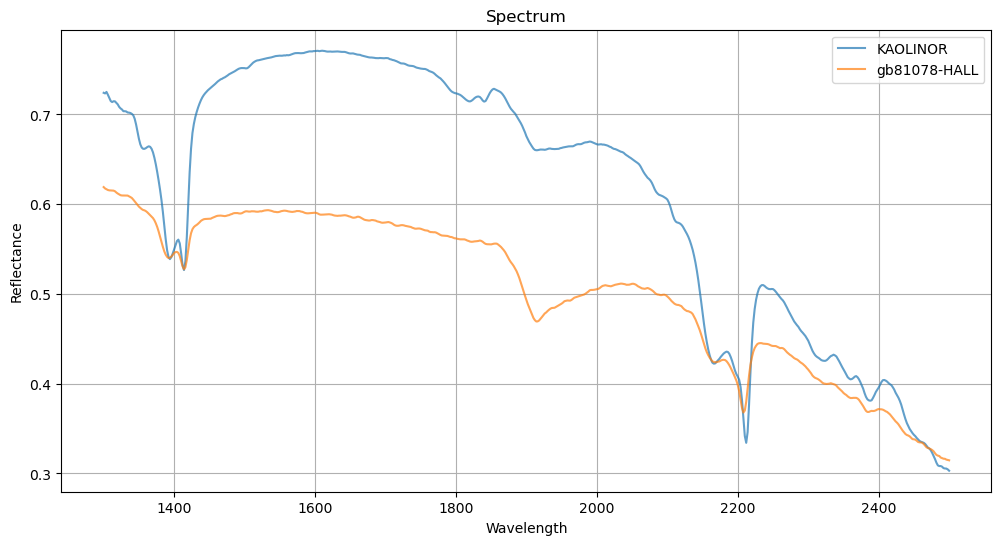

kaolinite的相似度：{'ALBITE': 2, 'ALUNITE1': 2, 'ALUNITE2': 4, 'ANDESINE': 3, 'ANHYDRIT': 0, 'ANORTHIT': 1, 'ANTIGORI': 2, 'ANTLERIT': 0, 'AZURITE': 2, 'BERYL': 2, 'BRUCITE': 2, 'CALCITE1': 0, 'CALCITE2': 1, 'CALCITE3': 0, 'CERUSSIT': 0, 'CHRYSOPR': 2, 'CORDIERI': 0, 'DICKITE': 3, 'DICKITE2': 3, 'DOLOMIT1': 1, 'DOLOMIT2': 1, 'EPIDOTE1': 0, 'EPIDOTE2': 0, 'EPIDOTE3': 1, 'GIBBSITE': 1, 'GLAUCONI': 1, 'GYPSUM1': 0, 'GYPSUM2': 0, 'GYPSUM3': 0, 'HALLOYSI': 4, 'HEMIMORP': 2, 'HYDAPOPH': 1, 'ILLITE': 2, 'ILLITE2': 2, 'JAROSIT1': 0, 'JAROSIT2': 0, 'KAOLINDI': 4, 'KAOLINOR': 7, 'LABRADOR': 1, 'MAGNESI2': 0, 'MAGNESIT': 1, 'MALACHIT': 2, 'MONTMOR2': 2, 'MONTMORI': 2, 'MUSCOVIT': 2, 'NATROJAR': 0, 'NATROLIT': 1, 'NH4ILLIT': 3, 'NONTRON1': 2, 'NONTRON2': 1, 'OLIGOCLA': 1, 'PALYGORS': 1, 'PHLOGOPI': 2, 'PLUMJARO': 0, 'PREHNITE': 1, 'PYROPHYL': 3, 'RHODOCRO': 1, 'SCHEELIT': 3, 'SCORODIT': 0, 'SEPIOLIT': 2, 'SERPENTI': 0, 'SIDERITE': 0, 'SMITHSON': 0, 'SODALITE': 1, 'STILBITE': 1, 'STRONTIA': 0, 'TALC': 2

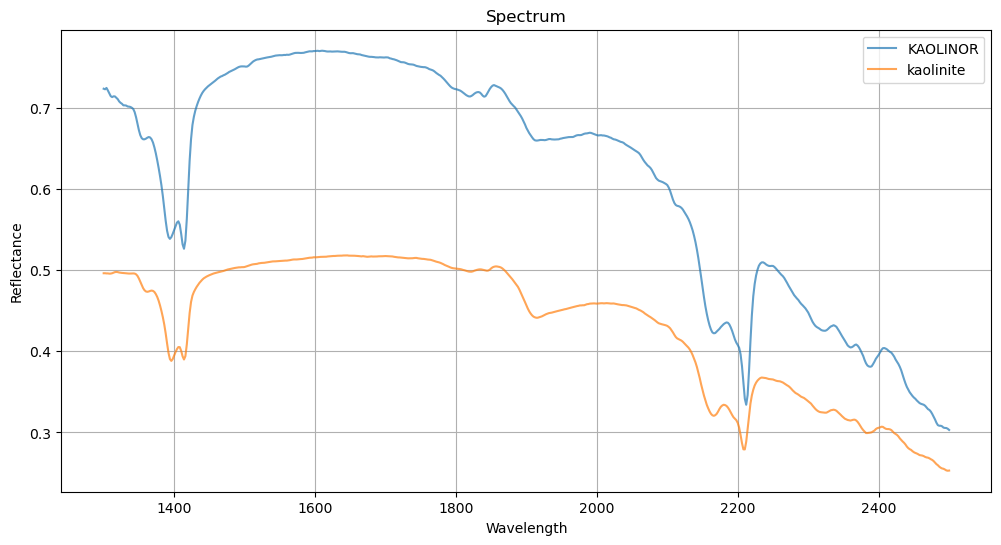

liquid water的相似度：{'ALBITE': 0, 'ALUNITE1': 0, 'ALUNITE2': 0, 'ANDESINE': 0, 'ANHYDRIT': 1, 'ANORTHIT': 0, 'ANTIGORI': 0, 'ANTLERIT': 0, 'AZURITE': 0, 'BERYL': 0, 'BRUCITE': 0, 'CALCITE1': 1, 'CALCITE2': 1, 'CALCITE3': 0, 'CERUSSIT': 0, 'CHRYSOPR': 0, 'CORDIERI': 0, 'DICKITE': 0, 'DICKITE2': 0, 'DOLOMIT1': 0, 'DOLOMIT2': 0, 'EPIDOTE1': 0, 'EPIDOTE2': 0, 'EPIDOTE3': 0, 'GIBBSITE': 1, 'GLAUCONI': 1, 'GYPSUM1': 1, 'GYPSUM2': 1, 'GYPSUM3': 1, 'HALLOYSI': 0, 'HEMIMORP': 0, 'HYDAPOPH': 1, 'ILLITE': 0, 'ILLITE2': 0, 'JAROSIT1': 0, 'JAROSIT2': 0, 'KAOLINDI': 0, 'KAOLINOR': 1, 'LABRADOR': 0, 'MAGNESI2': 0, 'MAGNESIT': 0, 'MALACHIT': 0, 'MONTMOR2': 1, 'MONTMORI': 1, 'MUSCOVIT': 1, 'NATROJAR': 0, 'NATROLIT': 0, 'NH4ILLIT': 0, 'NONTRON1': 0, 'NONTRON2': 0, 'OLIGOCLA': 0, 'PALYGORS': 1, 'PHLOGOPI': 1, 'PLUMJARO': 0, 'PREHNITE': 1, 'PYROPHYL': 0, 'RHODOCRO': 1, 'SCHEELIT': 0, 'SCORODIT': 0, 'SEPIOLIT': 0, 'SERPENTI': 0, 'SIDERITE': 0, 'SMITHSON': 1, 'SODALITE': 0, 'STILBITE': 0, 'STRONTIA': 0, 'TALC'

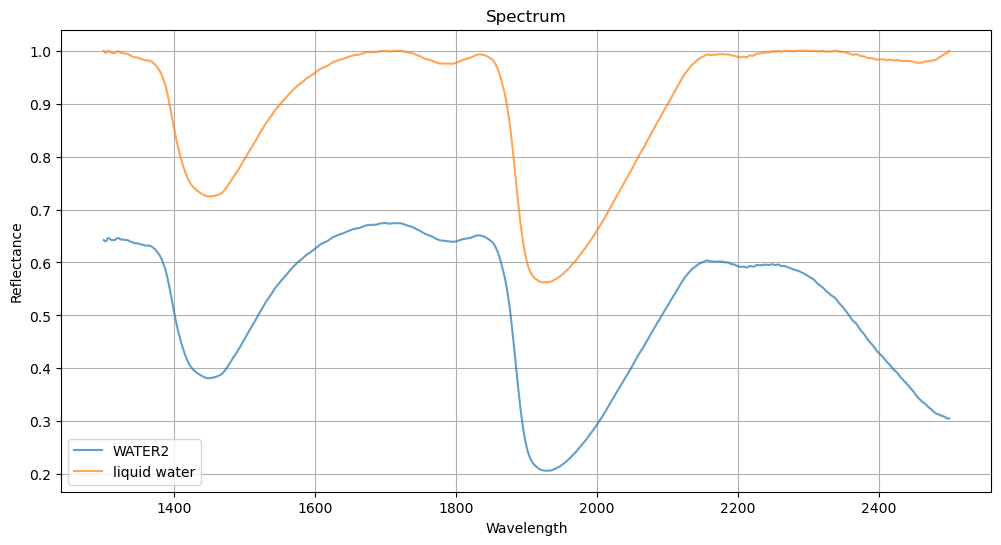

mottled white and iron stained-HALL的相似度：{'ALBITE': 3, 'ALUNITE1': 1, 'ALUNITE2': 3, 'ANDESINE': 3, 'ANHYDRIT': 0, 'ANORTHIT': 0, 'ANTIGORI': 1, 'ANTLERIT': 0, 'AZURITE': 2, 'BERYL': 1, 'BRUCITE': 0, 'CALCITE1': 0, 'CALCITE2': 1, 'CALCITE3': 0, 'CERUSSIT': 0, 'CHRYSOPR': 2, 'CORDIERI': 0, 'DICKITE': 3, 'DICKITE2': 3, 'DOLOMIT1': 0, 'DOLOMIT2': 0, 'EPIDOTE1': 0, 'EPIDOTE2': 0, 'EPIDOTE3': 0, 'GIBBSITE': 1, 'GLAUCONI': 1, 'GYPSUM1': 0, 'GYPSUM2': 0, 'GYPSUM3': 0, 'HALLOYSI': 4, 'HEMIMORP': 1, 'HYDAPOPH': 1, 'ILLITE': 3, 'ILLITE2': 4, 'JAROSIT1': 0, 'JAROSIT2': 0, 'KAOLINDI': 4, 'KAOLINOR': 5, 'LABRADOR': 1, 'MAGNESI2': 1, 'MAGNESIT': 0, 'MALACHIT': 2, 'MONTMOR2': 2, 'MONTMORI': 3, 'MUSCOVIT': 3, 'NATROJAR': 0, 'NATROLIT': 1, 'NH4ILLIT': 4, 'NONTRON1': 2, 'NONTRON2': 1, 'OLIGOCLA': 2, 'PALYGORS': 1, 'PHLOGOPI': 3, 'PLUMJARO': 0, 'PREHNITE': 1, 'PYROPHYL': 1, 'RHODOCRO': 1, 'SCHEELIT': 4, 'SCORODIT': 0, 'SEPIOLIT': 1, 'SERPENTI': 0, 'SIDERITE': 0, 'SMITHSON': 0, 'SODALITE': 0, 'STILBITE': 0

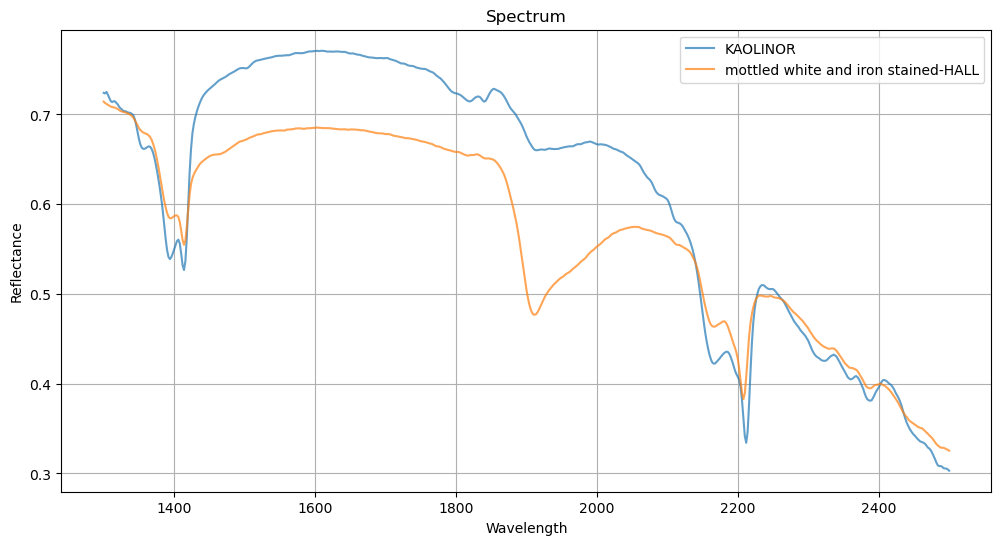

In [25]:
# 基于重合的峰位个数计算相似度
def count_peak_similarity(unknown_spectrum_peak_wavelengths, lib_spectrum_peak_wavelengths):
    count = 0
    start_index = 0
    for pwl in unknown_spectrum_peak_wavelengths:
        for i in range(start_index, len(lib_spectrum_peak_wavelengths)):
            lib_pwl = lib_spectrum_peak_wavelengths[i]
            if abs(pwl - lib_pwl) < 6:
                count += 1
                start_index = i
                break
    return count

def match_spectrums_by_peaks(unknown_spectrum, library):
    unknown_spectrum_peak_wavelengths = get_peak_wavelenghs_from_spectrum(unknown_spectrum)
    similarity = {}
    for name, lib_spectrum in library.items():
        lib_spectrum_peak_wavelengths = get_peak_wavelenghs_from_spectrum(lib_spectrum)
        similarity[name] = count_peak_similarity(unknown_spectrum_peak_wavelengths, lib_spectrum_peak_wavelengths)
    return similarity

# unknown_spectrum = pd.read_csv('./data/test/single/csv/mottled white and iron stained-HALL.csv')
# similarity = match_spectrums(unknown_spectrum, spectrum_lib)
# max_similarity_spectrum = max(similarity, key=similarity.get)
# print('最匹配的是：',max_similarity_spectrum)
# spectrum_result = {max_similarity_spectrum:spectrum_lib[str(max_similarity_spectrum)],
#                    'Unknown':unknown_spectrum}
# plot_spectrums(spectrum_result,attr='reflectance')

for name, spectrum in test_lib.items():
    similarity = match_spectrums_by_peaks(spectrum, spectrum_lib)
    print(f'{name}的相似度：{similarity}')
    max_similarity_spectrum = max(similarity, key=similarity.get)
    print(f'{name}最匹配的是：{max_similarity_spectrum}')
    spectrum_result = {max_similarity_spectrum:spectrum_lib[str(max_similarity_spectrum)],
                          name:spectrum}
    plot_spectrums(spectrum_result,attr='reflectance')

### 光谱角匹配

A6K4-AL最佳匹配是：ALUNITE2, 相似度：0.9981474197796402


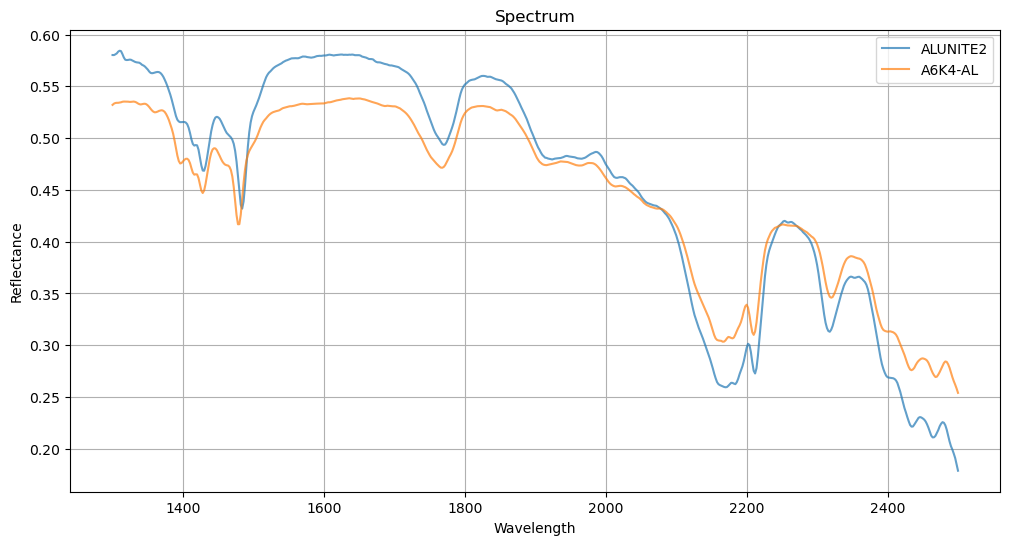

Alunite最佳匹配是：ALUNITE2, 相似度：0.9949396408012057


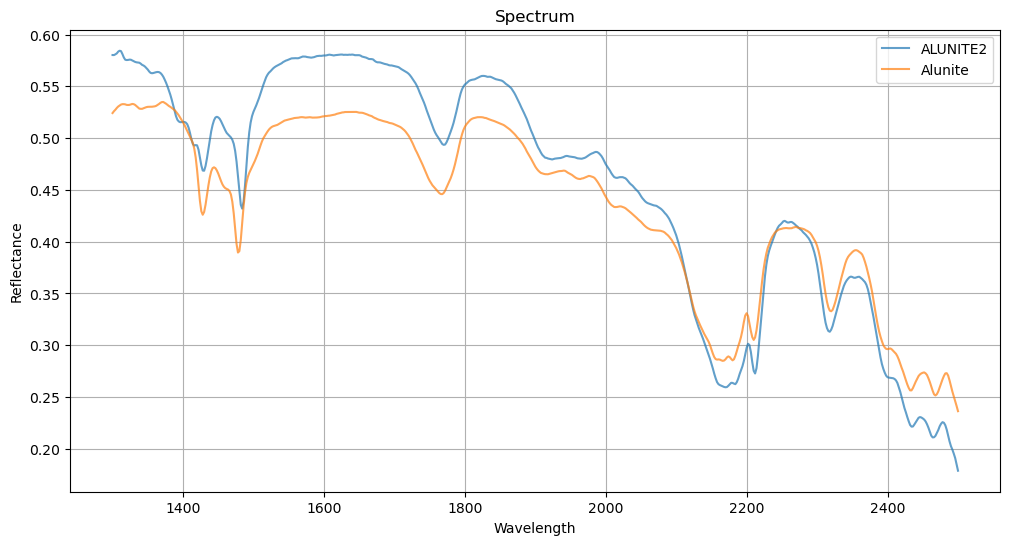

broken white surface最佳匹配是：HALLOYSI, 相似度：0.9950449426848154


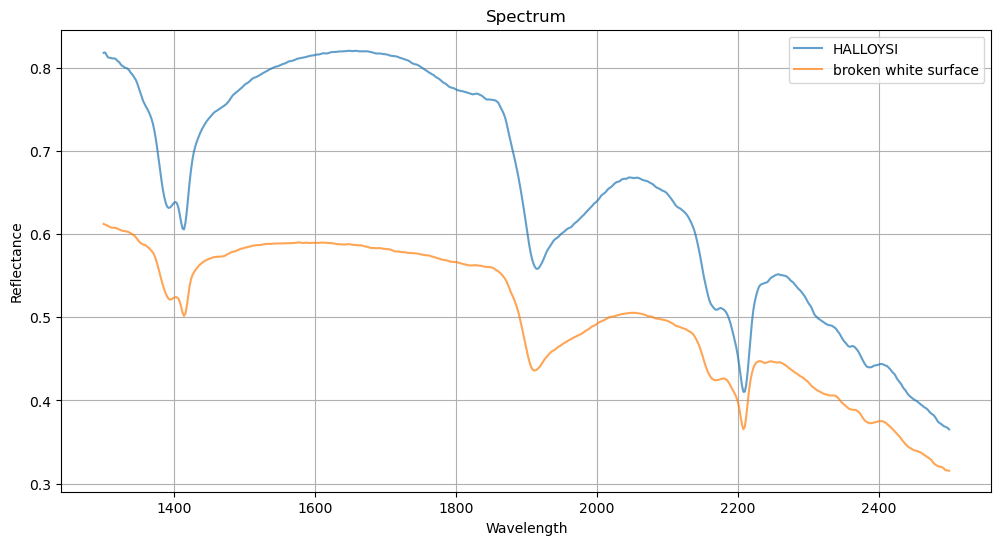

gb81075-HALL最佳匹配是：HALLOYSI, 相似度：0.9918422795456274


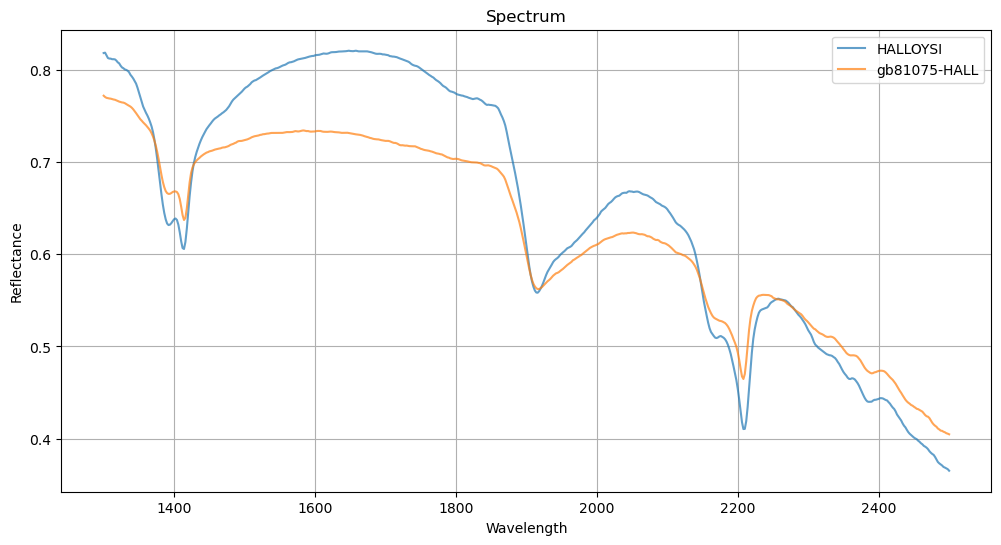

gb81078-HALL最佳匹配是：HALLOYSI, 相似度：0.9918289873324244


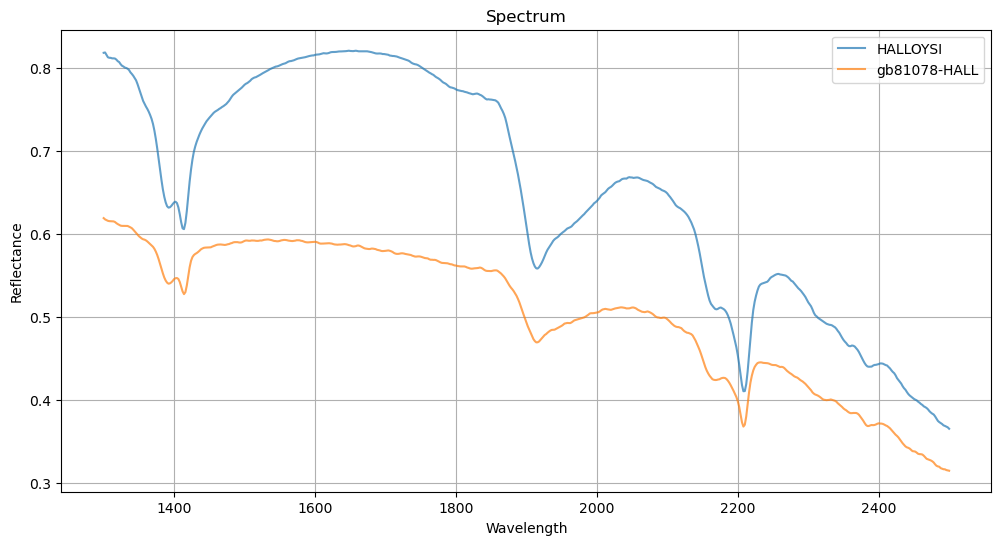

kaolinite最佳匹配是：KAOLINDI, 相似度：0.998650493413669


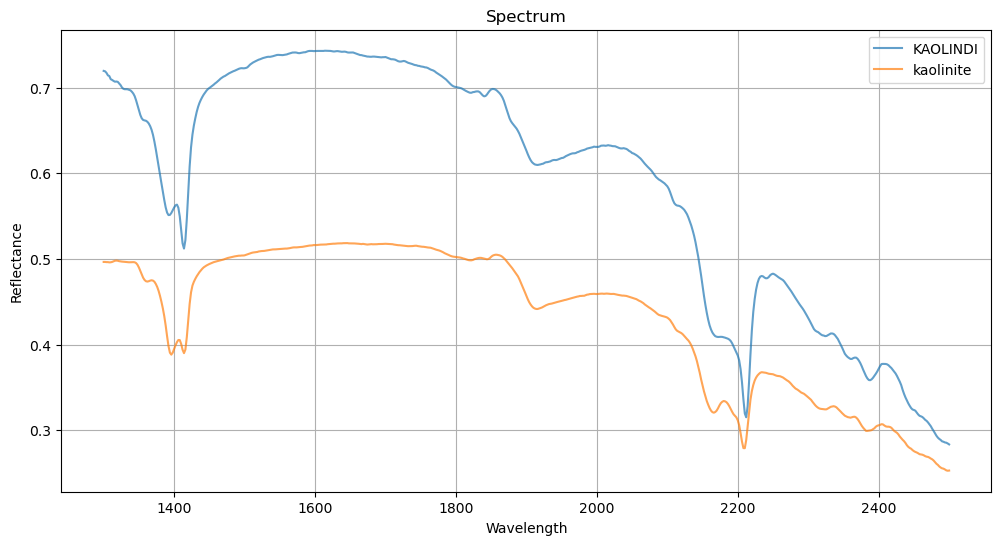

liquid water最佳匹配是：WATER2, 相似度：0.892059539967927


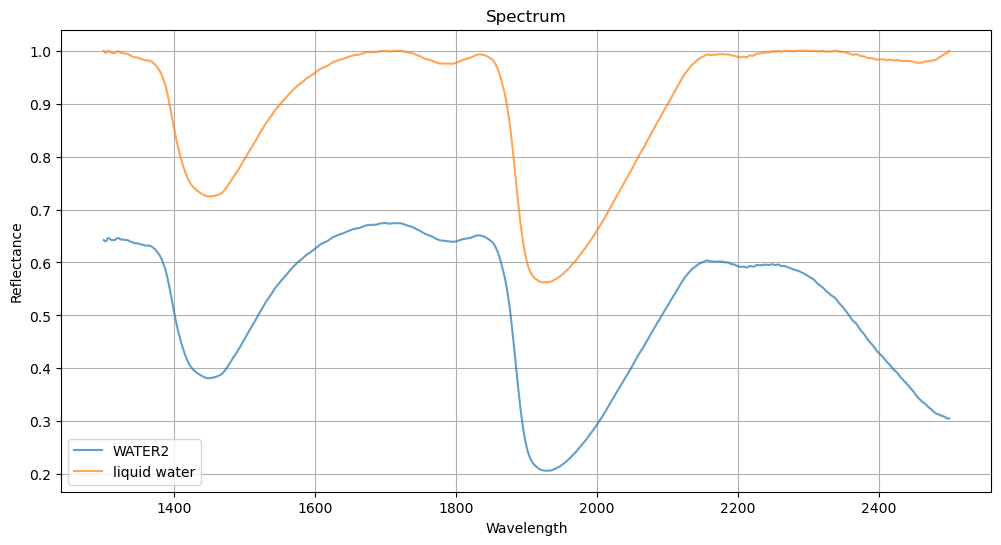

mottled white and iron stained-HALL最佳匹配是：HALLOYSI, 相似度：0.9959414434225224


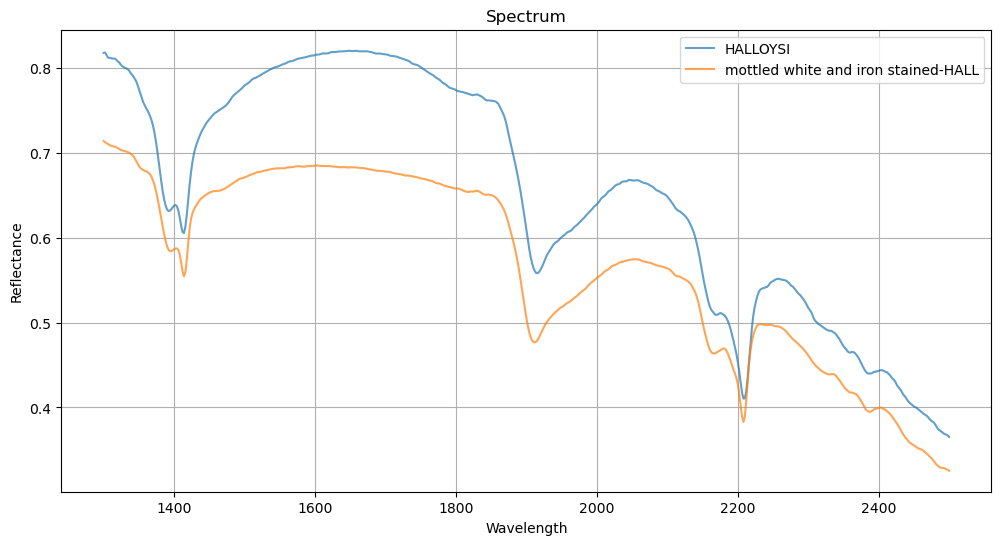

In [26]:
from scipy.ndimage import gaussian_filter

for test_name, test_spectrum in test_lib.items():
    # 初始化最大相似度和最佳匹配
    max_similarity = -1
    best_match = None
    # 归一化
    normalized_test= normalize(test_spectrum)
    for lib_name,lib_spectrum in spectrum_lib.items():
        # 归一化
        normalized_lib = normalize(lib_spectrum)
        # 计算余弦相似度
        similarity = cosine_similarity([normalized_test.values.flatten()], [normalized_lib.values.flatten()])[0][0]
        # 如果这个光谱的相似度更高，那么更新最大相似度和最佳匹配
        if similarity > max_similarity:
            max_similarity = similarity
            best_match = lib_name
    print(f'{test_name}最佳匹配是：{best_match}, 相似度：{max_similarity}')
    plot_spectrums({best_match:spectrum_lib[best_match],
                    test_name:test_spectrum},
                    attr='reflectance')


### 相关系数匹配

A6K4-AL最佳匹配是：ALUNITE2, 相似度：0.9964550400449467


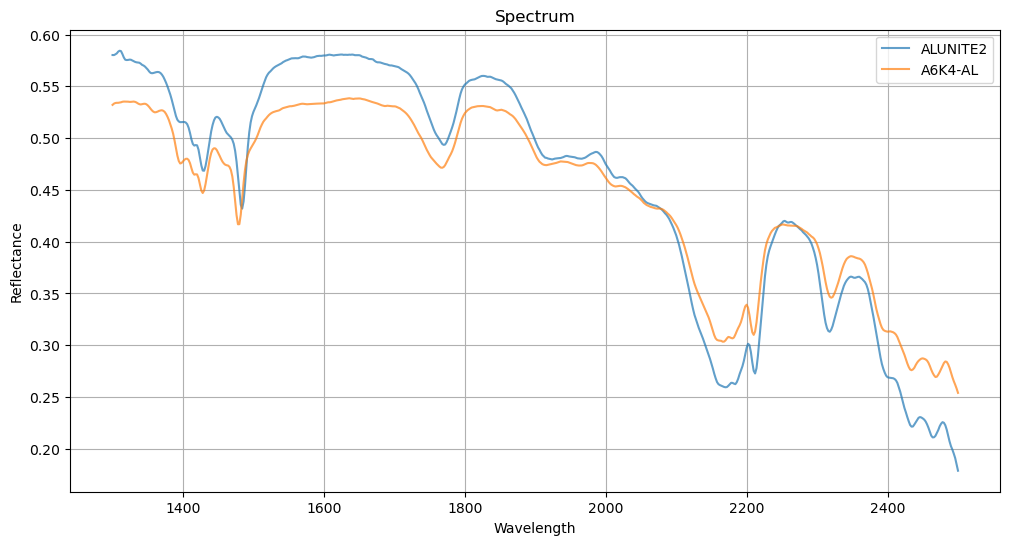

Alunite最佳匹配是：ALUNITE2, 相似度：0.9909703967575878


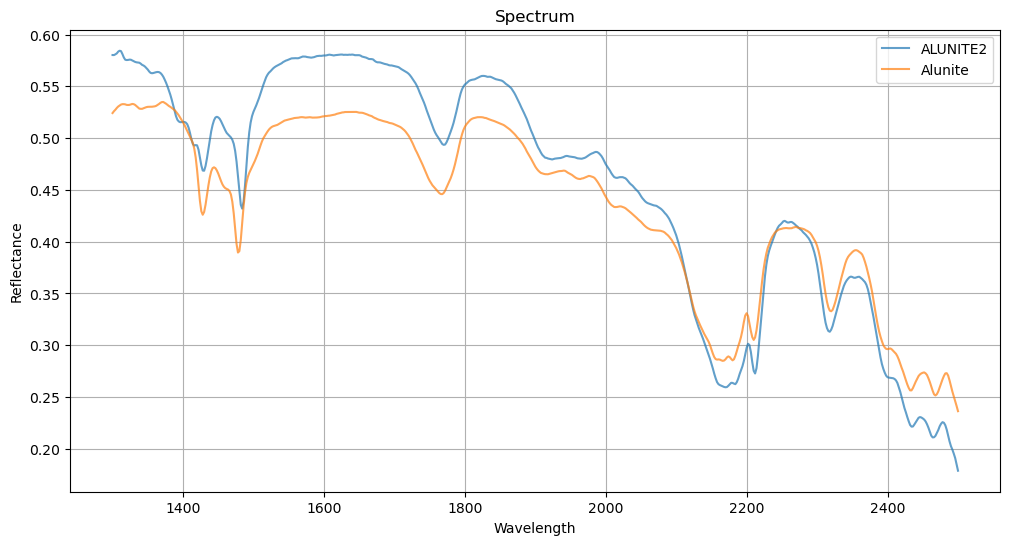

broken white surface最佳匹配是：HALLOYSI, 相似度：0.9914480966301858


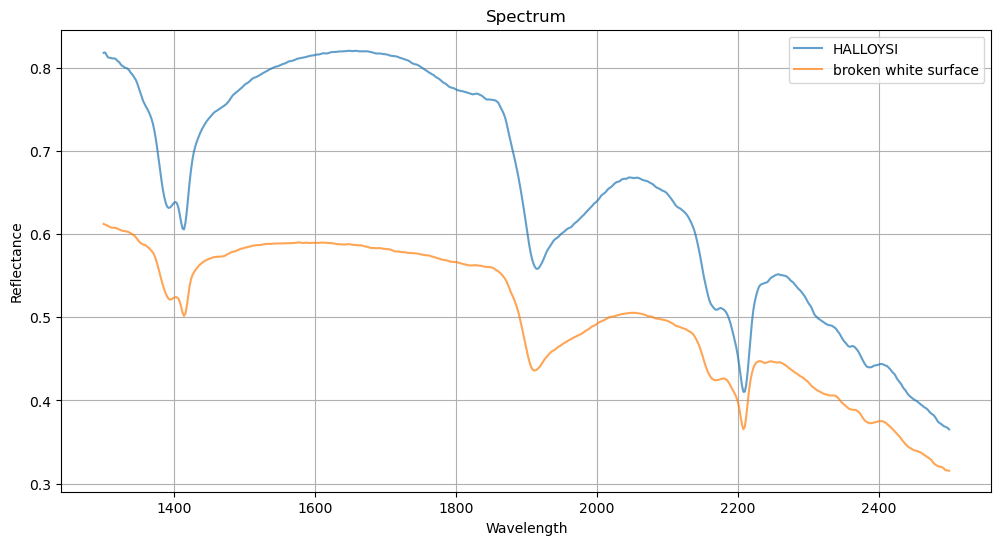

gb81075-HALL最佳匹配是：HALLOYSI, 相似度：0.9885745478720936


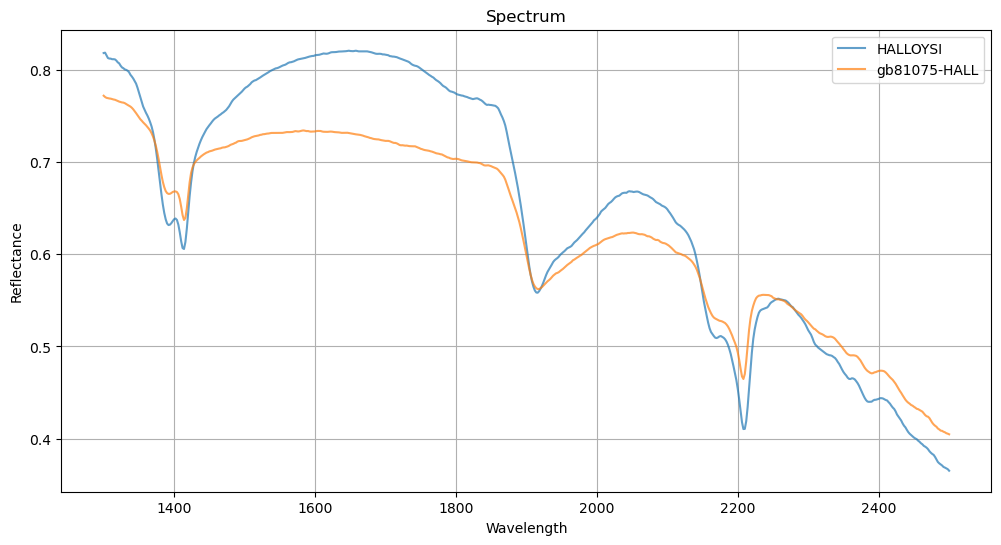

gb81078-HALL最佳匹配是：HALLOYSI, 相似度：0.9837851174228781


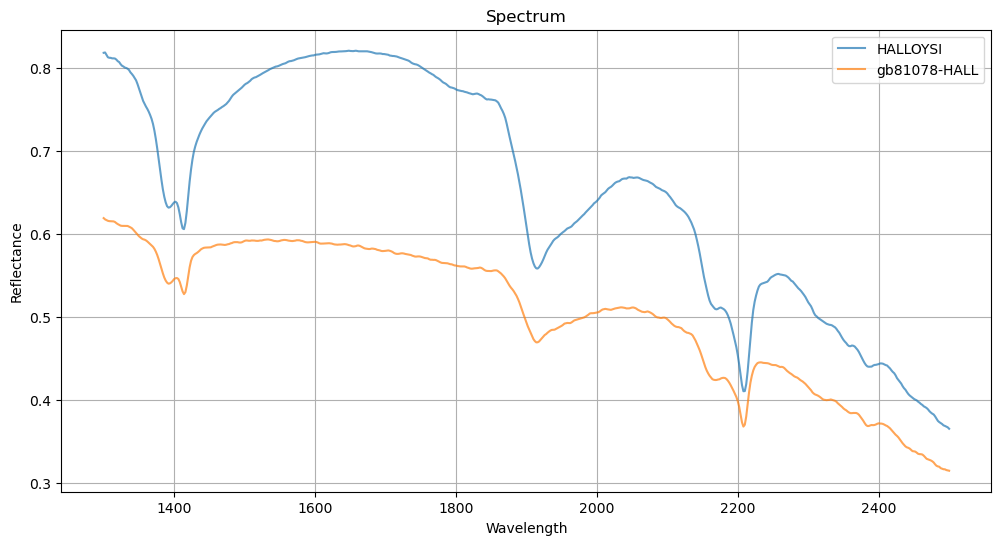

kaolinite最佳匹配是：KAOLINDI, 相似度：0.9974215066477335


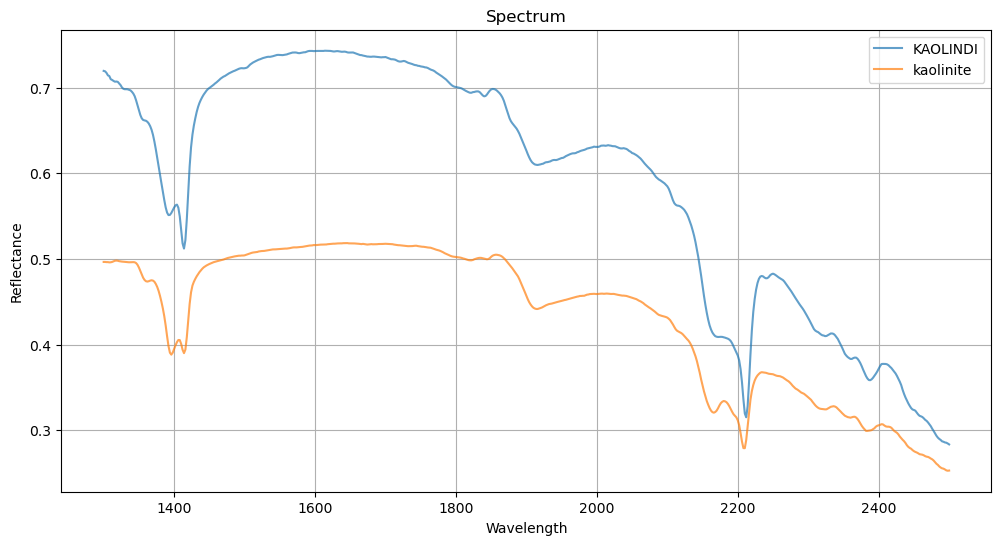

liquid water最佳匹配是：WATER2, 相似度：0.8390768961285657


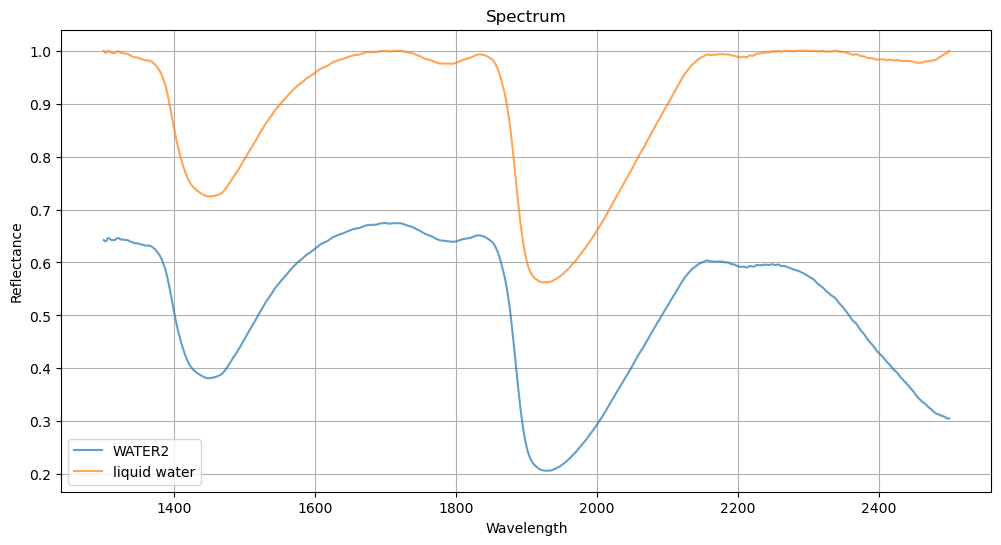

mottled white and iron stained-HALL最佳匹配是：HALLOYSI, 相似度：0.9926254960952269


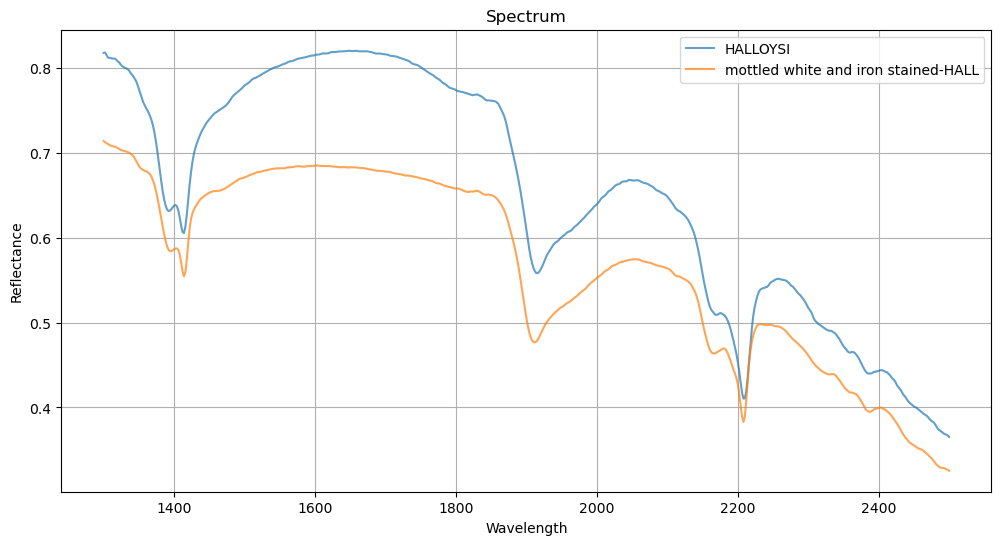

In [27]:
for test_name, test_spectrum in test_lib.items():
    # 初始化最大相似度和最佳匹配
    max_similarity = -1
    best_match = None
    # 归一化
    normalized_test= normalize(test_spectrum)
    for lib_name,lib_spectrum in spectrum_lib.items():
        # 归一化
        normalized_lib = normalize(lib_spectrum)
        # 计算余弦相似度
        similarity = np.corrcoef(normalized_test, normalized_lib)[0][1]
        # 如果这个光谱的相似度更高，那么更新最大相似度和最佳匹配
        if similarity > max_similarity:
            max_similarity = similarity
            best_match = lib_name
    # 输出结果
    print(f'{test_name}最佳匹配是：{best_match}, 相似度：{max_similarity}')
    plot_spectrums({best_match:spectrum_lib[best_match],
                    test_name:test_spectrum},
                    attr='reflectance')


## 混合光谱解混

In [10]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from scipy.spatial import distance
from numpy.linalg import inv, pinv
from scipy.optimize import nnls

def spectrum_to_matrix(spectrum_lib):
    # 将光谱库转化为矩阵
    matrix = []
    keys = []
    for key in spectrum_lib:
        matrix.append(spectrum_lib[key].values.flatten())
        keys.append(key)
    return np.array(matrix).T, keys  # 转置以使每个光谱成为一列

# 将光谱库转化为矩阵
library, keys = spectrum_to_matrix(spectrum_lib)

# 计算库的均值和协方差矩阵
mean = np.mean(library, axis=1)
cov = np.cov(library)

# 对每个未知光谱进行解混
for key in test_lib:
    unknown = test_lib[key].values.flatten()

    # 计算马氏距离
    mahalanobis_distance = distance.mahalanobis(unknown, mean, pinv(cov))

    # 使用PLS进行解混
    pls = PLSRegression(n_components=2)
    pls.fit(library, unknown)
    pls_result = pls.coef_

    # 使用NNLS进行解混
    nnls_result, _ = nnls(library, unknown)

    print(f"For spectrum {key}:")
    print(f"Mahalanobis distance: {mahalanobis_distance}")
    print("PLS result:")
    pls_tuples = [(keys[i], value) for i, value in enumerate(pls_result.flatten()) if value > 0]
    pls_tuples = sorted(pls_tuples, key=lambda x: x[1], reverse=True)[:3]  # 只保留最大的3个
    for key, value in pls_tuples:
        print(f"{key}: {value}")
    print("NNLS result:")
    nnls_tuples = [(keys[i], value) for i, value in enumerate(nnls_result) if value > 0]
    nnls_tuples = sorted(nnls_tuples, key=lambda x: x[1], reverse=True)[:3]  # 只保留最大的3个
    for key, value in nnls_tuples:
        print(f"{key}: {value}")


For spectrum A6K4-AL:
Mahalanobis distance: 15.889063302184898
PLS result:
TOURMALI: 40.1369652967272
MALACHIT: 28.33526874867906
AZURITE: 27.847418871333975
NNLS result:
ALUNITE2: 0.6420413419946669
LABRADOR: 0.15137565542927417
NH4ILLIT: 0.1501295896787685
For spectrum Alunite:
Mahalanobis distance: 18.067058475957612
PLS result:
TOURMALI: 46.11566594263746
MALACHIT: 31.522606063053214
AZURITE: 30.93733334035022
NNLS result:
ALUNITE2: 0.6580566784764772
ZIRCON: 0.09741124974722777
NH4ILLIT: 0.09006393836088918
For spectrum broken white surface:
Mahalanobis distance: 10.94932754742336
PLS result:
TSCHMERI: 19.5498956217336
TRONA: 19.3571431240199
KAOLINDI: 17.698389037432584
NNLS result:
KAOLINDI: 0.265926732288522
OLIGOCLA: 0.1817295583267973
NH4ILLIT: 0.16159821841256167
For spectrum gb81075-HALL:
Mahalanobis distance: 9.789269550284601
PLS result:
TALC: 40.09360672869259
NATROJAR: 32.96542873328174
MUSCOVIT: 31.320724207685146
NNLS result:
HALLOYSI: 0.3602869878601195
MUSCOVIT: 0.2